This notebook is for training the model.

In [17]:
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 5.4.1


In [18]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import keras.preprocessing.image as preprocess
from DataGenerator import *

The next two blocks contain parameters that you can change.

In [30]:
# importing images
#path = "/home/hippoc/schen/imgs_colors/"
path = "/home/hippoc/bin/beauvoir/data/thin_distract_plus/dataset/" # path where the training/validations sets are stored
test_path = "/home/hippoc/bin/beauvoir/data/crop_data/300x200/test/combined/" # path where the test set is stored

#image_num = 8000
#images = np.zeros((image_num, 200, 300, 3))
#for i in range(image_num):
#    img = preprocess.load_img(path + str(i)+'.png')
#    img_array = preprocess.img_to_array(img)
#    images[i] = img_array
    
# preprocessing images (range from 0 to 1)
#images /= 255.0

#datagen = ImageDataGenerator(
#        featurewise_center=True,
#        samplewise_center=False,
#        featurewise_std_normalization=True,
#        samplewise_std_normalization=False,
#        zca_whitening=True,
#        rotation_range=0,
#        width_shift_range=0,
#        height_shift_range=0,
#        horizontal_flip=False,
#        vertical_flip=False
#        )



In [31]:
input_shape = (200, 300, 3) # (height, width, channels) of images

image_num = 140800
training_labels = (0, 130800) # the image range for training
validation_labels = (130800, 140800) # the image range for validation

# Parameters
params = {'dim': input_shape[0:2],
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True}

The next blocks are for setting up the model and training.

In [32]:
partition = {}
partition['train'] = list(range(training_labels[0], training_labels[1]))
partition['validation'] = list(range(validation_labels[0], validation_labels[1]))

# importing labels
f = open(path + 'labels.txt', 'r')
labels = f.readlines()
labels = [eval(x.strip()) for x in labels]

# change labels to range from 0-num of pixels
labels = [(x[0] * 300, x[1] * 200) for x in labels]

# preprocessing labels (range from -1 to 1)
labels_orig = np.round(np.array([[tup[0], tup[1]] for tup in labels]))
labels = [[(tup[0]-(input_shape[1]/2))/(input_shape[1]/2), (tup[1]-(input_shape[0]/2))/-(input_shape[0]/2)] for tup in labels]
labels = np.array(labels)
labels_dict = {}
for i in range(image_num):
    labels_dict[i] = labels[i]

In [34]:
# testing that labels properly imported
print(labels_dict[152])
print(labels_dict[152].shape)

[-0.03295458 -0.        ]
(2,)


In [35]:
training_generator = DataGenerator(partition['train'], labels_dict, path=path, **params)
validation_generator = DataGenerator(partition['validation'], labels_dict, path=path, **params)

# testing that images loaded correctly
#plt.imshow(images[0])

#print(labels)
#X, y, indexes = training_generator.__getitem__(0)
#print(y[0])
#print(labels_dict[indexes[0]])

In [36]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, BatchNormalization, Activation
from keras.losses import mean_squared_error
from keras.optimizers import Adam
from keras.callbacks import History, ModelCheckpoint

def ResLayer(x, filters):
    # identity
    res = x
    res = BatchNormalization()(res)
    res = Conv2D(filters=filters, kernel_size=[1,1], strides=2, padding='same', use_bias=False)(res)
    
    # conv layers
    out = BatchNormalization()(x)
    out = Activation('relu')(out)
#    out = Activation('relu')(x)
    out = Conv2D(filters=filters, kernel_size=[3,3], strides=2, padding='same', use_bias=False)(out)
    
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(filters=filters, kernel_size=[3,3], strides=1, padding='same', use_bias=False)(out)
    
    # adding the identity
    out = keras.layers.add([res,out])
    
    return out

In [37]:
# input layer
inputs = Input(shape=input_shape)

x = Conv2D(filters=32, kernel_size=[5,5], strides=2, padding='same')(inputs)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = ResLayer(x, 32)
x = ResLayer(x, 64)
x = ResLayer(x, 128)

x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Flatten()(x)

x = Dense(2)(x)

model = Model(inputs=inputs, outputs=x)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 100, 150, 32) 2432        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 49, 74, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 49, 74, 32)   128         max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
activation

In [38]:
import keras.backend as K

def mean_mse(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true-y_pred), axis=-1))

In [40]:
# loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()

mc = ModelCheckpoint('/home/hippoc/schen/models/v6/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

In [ ]:
# actual model fitting using tuned hyperparameters

batch_size = 32
epochs = 10
lr = 0.0004508087977693204

# compile model
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=lr),
              metrics=[mean_mse]
              )

hist = model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           use_multiprocessing=False,
                           epochs=epochs,
                           callbacks=[history, mc],
                           )

Epoch 1/10
4087/4087 [==============================] - 3001s 734ms/step - loss: 2049.1761 - mean_mse: 0.0637 - val_loss: 108.4954 - val_mean_mse: 0.0436

Epoch 00001: saving model to /home/hippoc/schen/models/v6/weights.01-108.50.hdf5
Epoch 2/10
4087/4087 [==============================] - 2968s 726ms/step - loss: 1409.3765 - mean_mse: 0.0433 - val_loss: 108.3740 - val_mean_mse: 0.0435

Epoch 00002: saving model to /home/hippoc/schen/models/v6/weights.02-108.37.hdf5
Epoch 3/10
3017/4087 [=====================>........] - ETA: 17:50 - loss: 1409.1527 - mean_mse: 0.0433

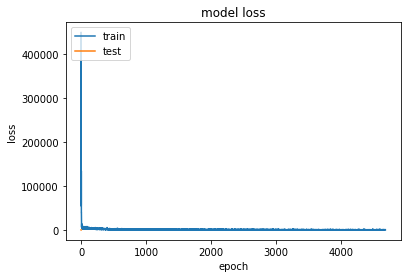

In [15]:
# summarize history for loss
plt.plot((np.array(range(len(history.losses))))/epochs, history.losses)
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The next blocks are for testing the model. They make predictions on images and then label images with a cross so that you can see whether or not the model is making good predictions.

In [17]:
# making annotations on validation data

#image_num = validation_labels[1] - validation_labels[0]
image_num = 100
images = np.zeros((image_num, input_shape[0], input_shape[1], input_shape[2]))
for i in range(image_num):
    img = preprocess.load_img(path + str(i+validation_labels[0])+'.png')
    img_array = preprocess.img_to_array(img)
    images[i] = img_array
    
# preprocessing images (range from 0 to 1)
images /= 255.0


x_pred = images
y_pred = labels[validation_labels[0]:validation_labels[0]+image_num]
preds = model.predict(x_pred, verbose=1)

100/100 [==============================] - 1s 6ms/step


In [18]:
preds[:,0] = preds[:,0]*150 + 150
preds[:,1] = preds[:,1]*-100 + 100
preds = np.round(preds)

In [20]:
from PIL import ImageDraw

for i in range(validation_labels[0],validation_labels[0]+image_num):
    img = Image.open(path + str(i)+'.png')
    draw = ImageDraw.Draw(img)
    
    pred = preds[i-validation_labels[0]]
    
    draw.line([tuple(pred - [10, 0]), tuple(pred + [10, 0])], fill="blue", width=3)
    draw.line([tuple(pred - [0, 10]), tuple(pred + [0, 10])], fill="red", width=3)

#    draw.point(labels_orig[i], fill="blue")
#    draw.point(preds[i-15840], fill="black")
    print(labels_orig[i], pred, labels_orig[i]- pred)
    img.save(path + "preds_cpu/" + str(i) + "_pred.png")

[160. 115.] [157. 111.] [3. 4.]
[209.  48.] [150. 101.] [ 59. -53.]
[96. 81.] [106.  78.] [-10.   3.]
[161.  97.] [148. 100.] [13. -3.]
[ 79. 141.] [ 79. 128.] [ 0. 13.]
[184.  70.] [179.  68.] [5. 2.]
[152.  49.] [153.  56.] [-1. -7.]
[145.  67.] [145.  75.] [ 0. -8.]
[223.  70.] [189.  80.] [ 34. -10.]
[148. 116.] [149. 117.] [-1. -1.]
[ 80. 153.] [ 95. 151.] [-15.   2.]
[167.  74.] [161.  82.] [ 6. -8.]
[166. 121.] [168. 115.] [-2.  6.]
[119. 138.] [117. 130.] [2. 8.]
[147. 102.] [151. 104.] [-4. -2.]
[216.  76.] [204.  83.] [12. -7.]
[69. 92.] [80. 94.] [-11.  -2.]
[184.  85.] [179.  89.] [ 5. -4.]
[135.  98.] [138.  99.] [-3. -1.]
[193. 118.] [195. 113.] [-2.  5.]
[151. 110.] [146. 107.] [5. 3.]
[165. 108.] [162. 104.] [3. 4.]
[146.  82.] [146.  86.] [ 0. -4.]
[221.  64.] [216.  76.] [  5. -12.]
[150. 127.] [152. 123.] [-2.  4.]
[140.  86.] [142.  90.] [-2. -4.]
[121.  49.] [126.  53.] [-5. -4.]
[198.  97.] [193.  98.] [ 5. -1.]
[87. 88.] [104.  91.] [-17.  -3.]
[115.  90.] [123. 

In [ ]:
# making predictions on test data

test_image_num = 5000

test_images = np.zeros((test_image_num, input_shape[0], input_shape[1], input_shape[2]))
for i in range(test_image_num):
    img = preprocess.load_img(test_path + str(i)+'.png')
    img_array = preprocess.img_to_array(img)
    test_images[i] = img_array
    
# preprocessing images (range from 0 to 1)
test_images /= 255.0


test_x_pred = test_images


# importing test labels
f = open(test_path + 'labels.txt', 'r')
test_labels = f.readlines()
test_labels = [eval(x.strip()) for x in test_labels]

# change labels to range from 0-num of pixels
test_labels_pics = [(x[0] * 300, x[1] * 200) for x in test_labels]

test_y_pred = test_labels

E0730 15:42:58.861174 139782654879488 alias.py:221] Invalid alias: The name clear can't be aliased because it is another magic command.
E0730 15:42:59.076416 139782654879488 alias.py:221] Invalid alias: The name more can't be aliased because it is another magic command.
E0730 15:42:59.087614 139782654879488 alias.py:221] Invalid alias: The name less can't be aliased because it is another magic command.
E0730 15:42:59.090473 139782654879488 alias.py:221] Invalid alias: The name man can't be aliased because it is another magic command.


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f218cf4f8c8> (for post_execute):

In [ ]:
# making predictions on test data
test_preds = model.predict(test_x_pred, verbose=1)

# converting to pixel locations
test_preds[:,0] = test_preds[:,0]*150 + 150
test_preds[:,1] = test_preds[:,1]*-100 + 100
test_preds = np.round(test_preds)
print(test_preds)

In [20]:
# evaluating and printing results on test data
test_results = model.evaluate(x=test_x_pred, y=test_y_pred)

print(test_results)

NameError: name 'test_x_pred' is not defined

In [21]:
from PIL import ImageDraw

for i in range(test_image_num):
#for i in range(200):
    img = Image.open(path + "test/"+ str(i)+'.png')
    draw = ImageDraw.Draw(img)
    
    pred = test_preds[i]
    
    draw.line([tuple(pred - [10, 0]), tuple(pred + [10, 0])], fill="blue", width=3)
    draw.line([tuple(pred - [0, 10]), tuple(pred + [0, 10])], fill="red", width=3)

#    draw.point(labels_orig[i], fill="blue")
#    draw.point(preds[i-12000], fill="black")
    print(labels_orig[i], test_preds[i], labels_orig[i]- test_preds[i])
    img.save(path + "test/" + "preds_cpu/" + str(i) + "_pred.png")

FileNotFoundError: [Errno 2] No such file or directory: '/home/hippoc/bin/beauvoir/data/crop_data/300x200/combined/test/0.png'

In [16]:
# SAVE THE MODEL IF IT'S GOOD
model.save_weights('/home/hippoc/schen/models/300_200_resnet8_gates_model_300k_w_noise.h5')

In [23]:
# making annotations on random data

#image_num = validation_labels[1] - validation_labels[0]
image_num = 100
images = np.zeros((image_num, input_shape[0], input_shape[1], input_shape[2]))
for i in range(image_num):
    img = preprocess.load_img(path + "new/" + str(i)+'.png')
    img_array = preprocess.img_to_array(img)
    images[i] = img_array
    
# preprocessing images (range from 0 to 1)
images /= 255.0


x_pred = images
preds = model.predict(x_pred, verbose=1)

preds[:,0] = preds[:,0]*150 + 150
preds[:,1] = preds[:,1]*-100 + 100
preds = np.round(preds)

from PIL import ImageDraw

for i in range(image_num):
    img = Image.open(path + "new/" + str(i)+'.png')
    draw = ImageDraw.Draw(img)
    
    pred = preds[i]
   
    draw.line([tuple(pred - [10, 0]), tuple(pred + [10, 0])], fill="blue", width=3)
    draw.line([tuple(pred - [0, 10]), tuple(pred + [0, 10])], fill="red", width=3)

#    draw.point(labels_orig[i], fill="blue")
#    draw.point(preds[i-15840], fill="black")
    print(labels_orig[i])
    img.save(path + "new/" + "preds_cpu/" + str(i) + "_pred.png")

FileNotFoundError: [Errno 2] No such file or directory: '/home/hippoc/bin/beauvoir/data/crop_data/300x200/combined/new/0.png'